# Exploration of the shap values

In [ ]:
run init.ipynb

388 administrations left.


,id
diagnosis,
0.0,332
1.0,56


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.868,0.645,0.937,0.346,0.991,0.67,0.175,0.67,0.326,0.825,0.478,0.75,0.837,0.438,0.097,0.952,0.25,0.562,0.048,42,278,54,14


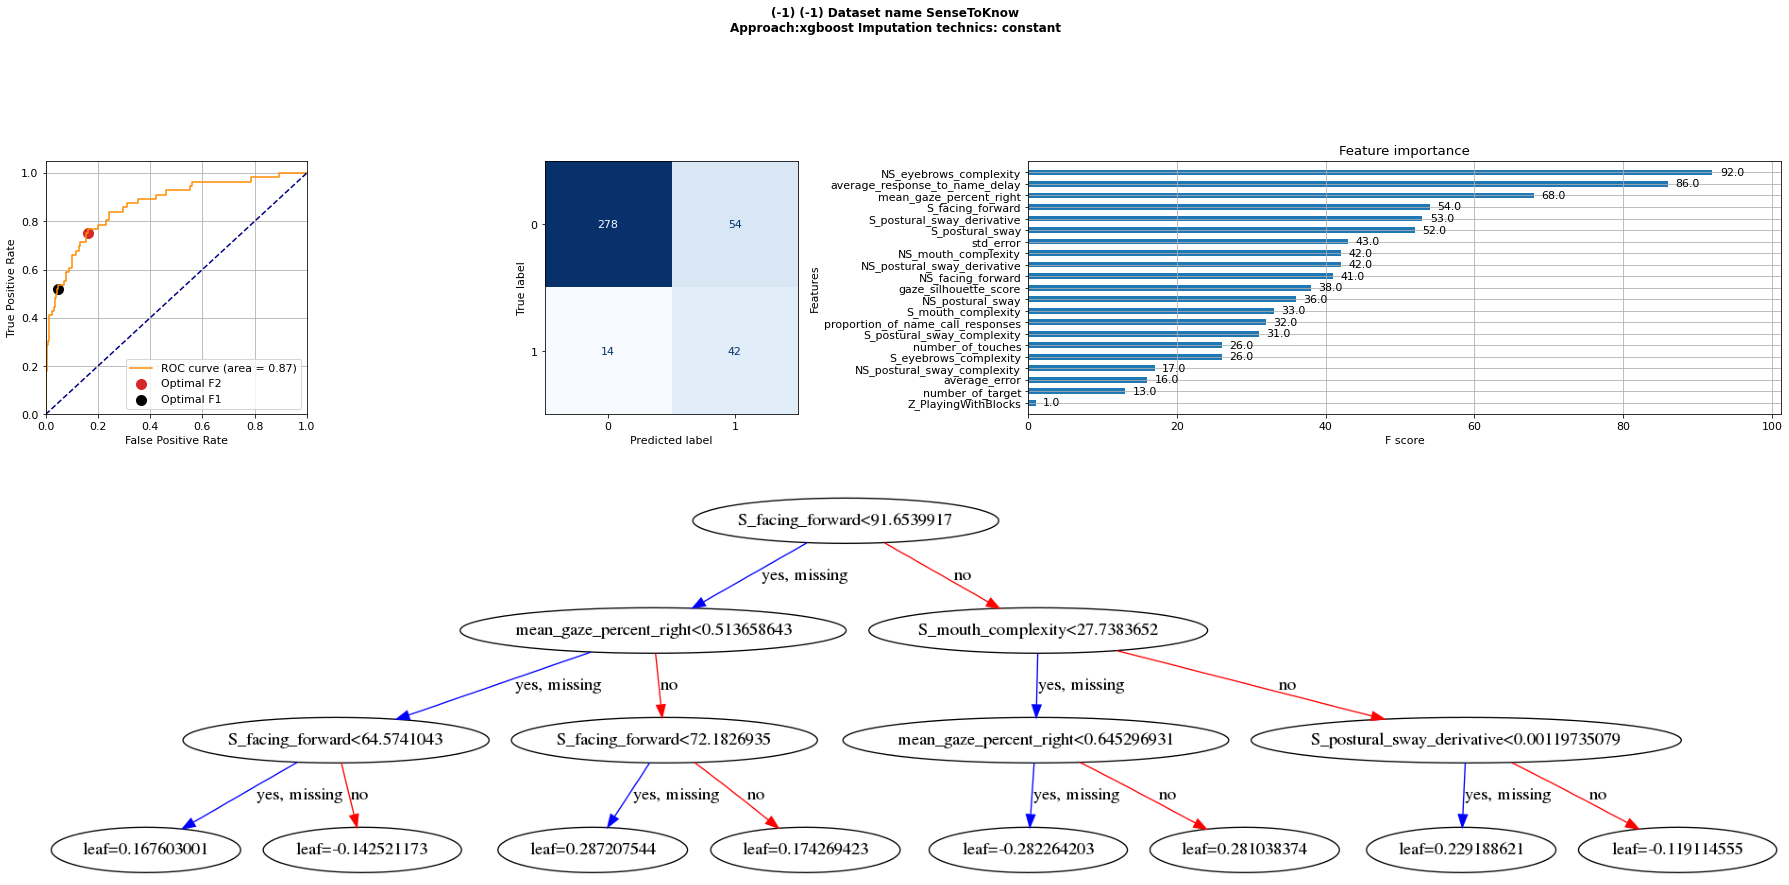

In [383]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()



In [4]:
exp_backup = deepcopy(exp)

# Shap values stability analysis

## Analysis of the stability of the models through Shap values investigation 


The question is to know whether from one model to another (train with or without subject i), the shap values are significantly different or not. If training is ribust, it should not! 

In [635]:
# This graph shows that when ASD are reoved, the expected value of the model is lower i.e. the probability of being NT increase.

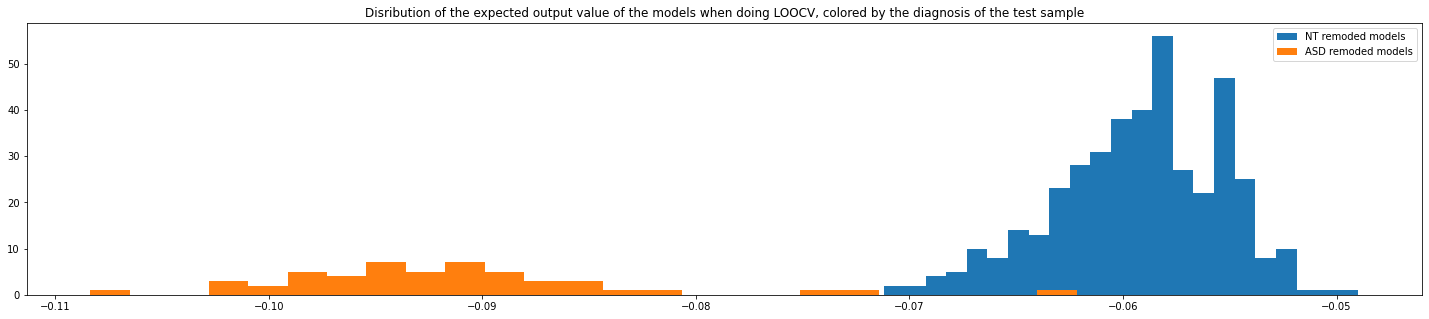

In [12]:
fi(25, 5)
plt.title("Disribution of the expected output value of the models when doing LOOCV, colored by the diagnosis of the test sample")
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==0].index)], color='tab:blue', bins=25, label='NT remoded models')
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)], color='tab:orange', bins=25, label='ASD remoded models')
_ = plt.legend()

In [26]:
# Unique case on the right:
np.argsort(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)])
print(np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)[31])
exp.predictions_df[366:367]

,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,S_postural_sway_complexity,NS_postural_sway_complexity,S_facing_forward,NS_facing_forward,S_eyebrows_complexity,NS_eyebrows_complexity,S_mouth_complexity,NS_mouth_complexity,std_error,number_of_touches,number_of_target,average_error,Z_PlayingWithBlocks,Z_FunAtThePark,Z_BlowingBubbles,Z_RhymesAndToys,y_true,y_pred,TN,TP,FP,FN,pred_class,sample_weight
366,NaN,NaN,NaN,0.617283,NaN,1.990688,NaN,0.010127,NaN,0.0,NaN,57.655955,NaN,31.046416,NaN,28.464212,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,0.456584,0,1,0,0,TP,0.102222


**We first differentiate the shap values associated with the present features from the missing features, to disambiguate the contribution of missing features and actual features values.**

In [221]:
n_models, n_participants, n_features = exp.shap_values.shape


extended_shap_values = np.zeros((n_models, n_participants, 2*n_features))
for idx_model in range(n_models):
    
    shap_value_models = exp.shap_values[idx_model, :, :]
    
    mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
    shap_present = np.multiply(shap_value_models, mask_shap_present)
    shap_missing = np.multiply(shap_value_models, (mask_shap_present==0).astype(int))
    
    # Normalized shap value separating real variables and when there are missing.
    general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
    shap_present_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
    general_shap_values_normalized  = general_shap_values / np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
    extended_shap_values[idx_model, :, :] = general_shap_values_normalized
    
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]                  


In [189]:
import shap

# Compute the shap values with the model fit with all the data
explainer = shap.TreeExplainer(exp.model)
expected_value_fit = explainer.expected_value
shap_values_fit  = explainer.shap_values(exp.dataset.X_train)

# Disambuguate present and missing variables 
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_fit, mask_shap_present)
shap_missing = np.multiply(shap_values_fit, (mask_shap_present==0).astype(int))

# Normalized shap value separating real variables and when there are missing.
general_shap_values_fit = np.concatenate([shap_present, shap_missing], axis=1)
shap_present_fit_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
shap_values_fit_normalized  = general_shap_values_fit / np.abs(general_shap_values_fit).sum(axis=1)[:, np.newaxis]

# Compute the Shap Values for indiviuals through the cross validation

shap_values = np.zeros(extended_shap_values.shape)
for i in range(exp.dataset.num_samples):
    shap_values[i, :] = extended_shap_values[i, i, :]
    
shap_values_normalized = shap_values / np.abs(shap_values).sum(axis=1)[:, np.newaxis]


The Following two graphs show the features comtribution for all the participants in two cases:

- Using the normalized sShap values recorded for each participants when doing the cross-validation: those are the actual true Shap value that explain the final prediction. 
- When fitting the model with all the training data (not removing the hold-out test participant). 

Providing that the traning is robust and that the model does not overfit on the training data, these Shap values shoul be very close. 
At first sight it seems relatively close, but there are some changes in the ordering of the features for instance, which might change the conclusion, so we need to dive deeper and quantify these Sahp values variations. 




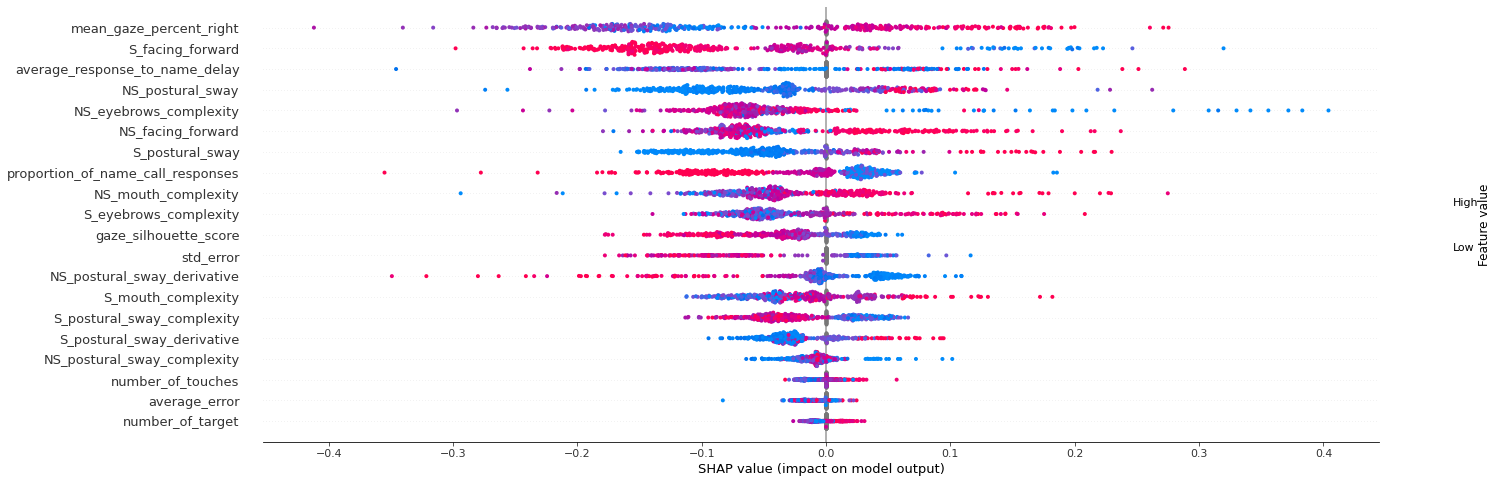

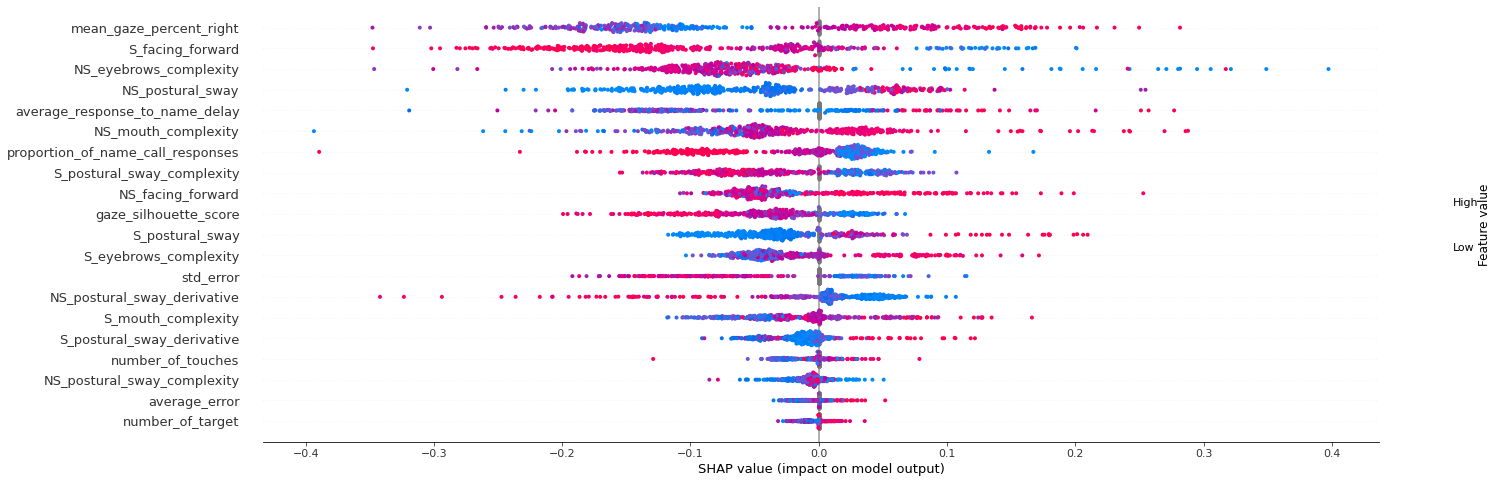

In [208]:
shap.summary_plot(shap_present_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values with CV")
shap.summary_plot(shap_present_fit_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values fitting all the model")

In order to quantify the fluctuations of the Shap Values due to different traning data being used, let's look at: 
- Local variation: for each of the participants, what is the variance of their Shap value over different tranining ? 
- Global variation: Over the different traning, what is the variance of the contribution of each features ? 

Subject:419


,id,diagnosis,language,app_version,subject,administration,features_extracted,face_tracking,age,timestamp,date,time,study,stimuli_version,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,valid_name_calls,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,PB_postural_sway,PB_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,repeat_percentage,repeat_percentage_naive,double_tap,mean_velocity,std_velocity,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,validity_available,completed,StateOfTheChild,SiblingsInTheRoom,ShotsVaccines,Distractions,FamilyMemberDistract,PetDistract,PetNoiseDistract,DoorbellPhoneDistract,TVOnDistract,OtherDistract,SittingUp,Hungry,Diaper,AppTeamComment,Comments,path,FB_head_movement_complexity,DIGC_head_movement_complexity,DIGRRL_head_movement_complexity,ST_head_movement_complexity,MP_head_movement_complexity,PB_head_movement_complexity,BB_head_movement_complexity,RT_head_movement_complexity,MML_head_movement_complexity,PWB_head_movement_complexity,FP_head_movement_complexity,FB_facing_forward,DIGC_facing_forward,DIGRRL_facing_forward,ST_facing_forward,MP_facing_forward,PB_facing_forward,BB_facing_forward,RT_facing_forward,MML_facing_forward,PWB_facing_forward,FP_facing_forward,FB_eyebrows_complexity,DIGC_eyebrows_complexity,DIGRRL_eyebrows_complexity,ST_eyebrows_complexity,MP_eyebrows_complexity,PB_eyebrows_complexity,BB_eyebrows_complexity,RT_eyebrows_complexity,MML_eyebrows_complexity,PWB_eyebrows_complexity,FP_eyebrows_complexity,FB_mouth_complexity,DIGC_mouth_complexity,DIGRRL_mouth_complexity,ST_mouth_complexity,MP_mouth_complexity,PB_mouth_complexity,BB_mouth_complexity,RT_mouth_complexity,MML_mouth_complexity,PWB_mouth_complexity,FP_mouth_complexity,remote,administration_number,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,S_postural_sway_complexity,NS_postural_sway_complexity,S_facing_forward,NS_facing_forward,S_eyebrows_complexity,NS_eyebrows_complexity,S_mouth_complexity,NS_mouth_complexity,S_postural_sway_conf,NS_postural_sway_conf,S_postural_sway_derivative_conf,NS_postural_sway_derivative_conf,gaze_silhouette_score_conf,mean_gaze_percent_right_conf,S_facing_forward_conf,NS_facing_forward_conf,S_eyebrows_complexity_conf,NS_eyebrows_complexity_conf,S_mouth_complexity_conf,NS_mouth_complexity_conf,S_postural_sway_complexity_conf,NS_postural_sway_complexity_conf,RTN_conf,touch_conf,Z_PlayingWithBlocks,Z_FunAtThePark,Z_BlowingBubbles,Z_RhymesAndToys
419,850897,1.0,English,2.1,<Subject.S2KSubject object at 0x7fea92a0f990>,<Administration.S2KAdministration object at 0x...,1,1,20.360656,Admin1,2020-02-11,00:00,ARC,Preschool,M,Not Hispanic/Latino,White/Caucasian,8.0,NaN,30.0,29.0,20.0,30.0,51.0,8.0,10.0,7.0,NaN,NaN,NaN,3.0,5.0,6.0,4.0,1.0,0.58159,0.486084,0.529963,0.65558

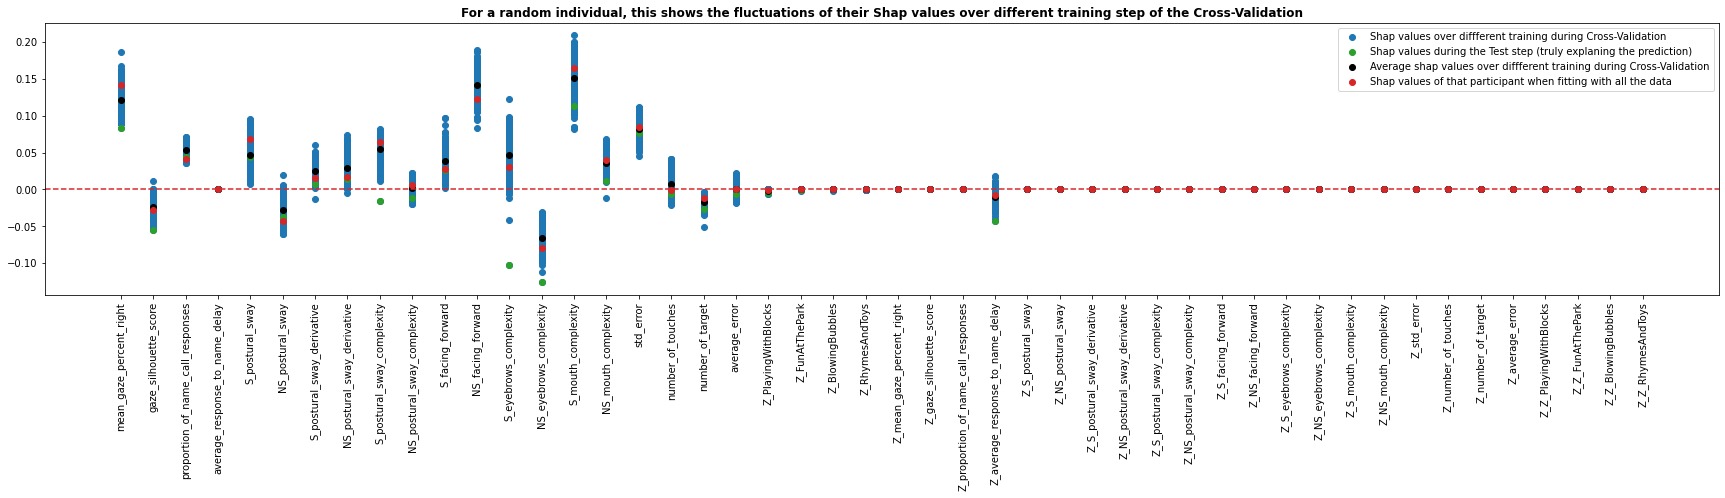

In [237]:
subject_of_interest = np.random.randint(467)
print("Subject:{}".format(subject_of_interest))
display(exp.dataset.df.iloc[subject_of_interest:subject_of_interest+1])

fi(30, 5)
n_model = exp.shap_values.shape[0]
plt.title("For a random individual, this shows the fluctuations of their Shap values over different training step of the Cross-Validation", weight='bold')
for i, feature_name  in enumerate(labels):
    plt.scatter([i]*n_model, extended_shap_values[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], extended_shap_values[subject_of_interest, subject_of_interest, i], color='tab:green', label="Shap values during the Test step (truly explaning the prediction)" if i==0 else None)
    plt.scatter([i], extended_shap_values.mean(axis=0)[subject_of_interest, i], color='k', label="Average shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], shap_values_fit_normalized[subject_of_interest, i], color='tab:red', label="Shap values of that participant when fitting with all the data" if i==0 else None)

plt.axhline(0, linestyle='--', color='tab:red')
plt.legend()


_  = plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.show()

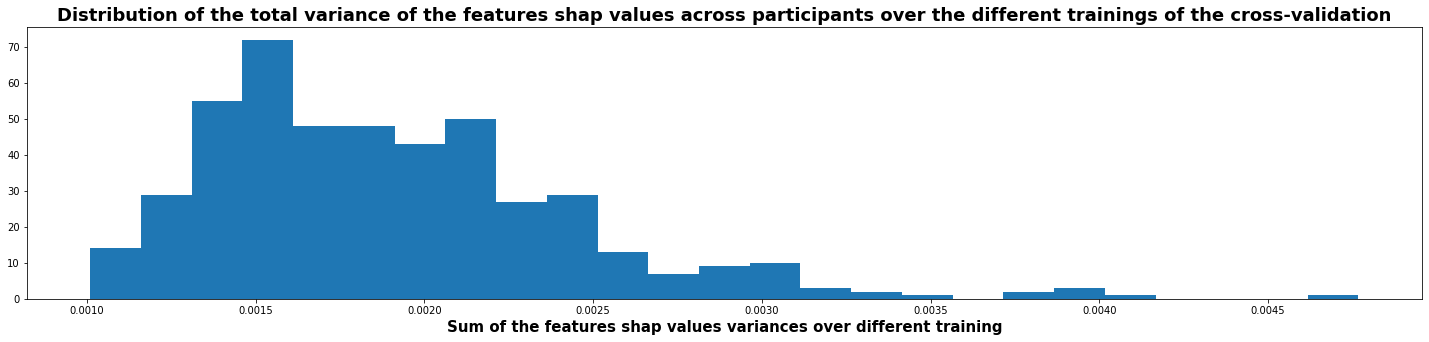

In [226]:
var_list = []
for subject_of_interest in range(467):
    var = 0
    for i, feature_name  in enumerate(labels):
        var+=np.var(extended_shap_values[:, subject_of_interest, i])
    var_list.append(var)
    
    
fi(25, 5)
plt.title("Distribution of the total variance of the features shap values across participants over the different trainings of the cross-validation", weight='bold', fontsize=18)
plt.hist(var_list, bins=25)
_ = plt.xlabel("Sum of the features shap values variances over different training", weight='bold', fontsize=15)


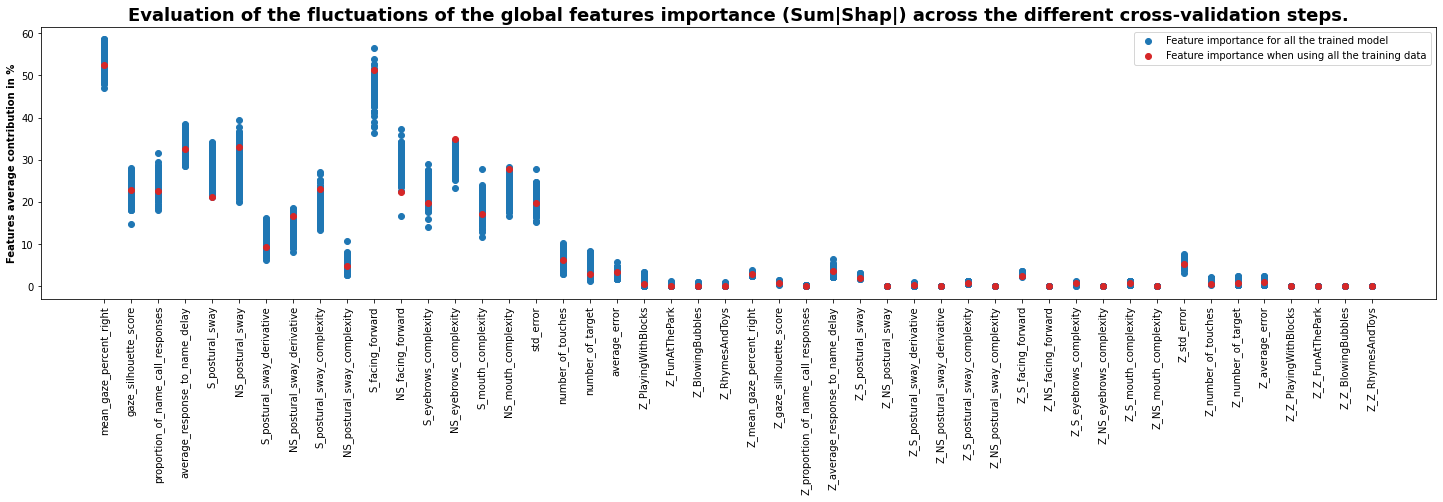

In [228]:
# Compute the global feature importance for each of the trained model and features, by summing over the rows of each @d Matrix shap values
features_importance_all_models_cv = np.abs(extended_shap_values).sum(axis=1)

# Plot the features importance of a few models
fi(25, 5)
plt.title("Evaluation of the fluctuations of the global features importance (Sum|Shap|) across the different cross-validation steps.", weight='bold', fontsize=18)
for idx_model in range(extended_shap_values.shape[0]):
    feature_importance = features_importance_all_models_cv[idx_model]#.std(axis=0)
    plt.scatter(np.arange(feature_importance.shape[0]), feature_importance, color='tab:blue', label = "Feature importance for all the trained model" if idx_model==0 else None)
    
plt.scatter(np.arange(feature_importance.shape[0]), np.abs(shap_values_fit_normalized).sum(axis=0), color='tab:red', label = "Feature importance when using all the training data")
plt.legend(); plt.ylabel("Features average contribution in %", weight='bold')
_ = plt.xticks(np.arange(feature_importance.shape[0]), labels, rotation=90)

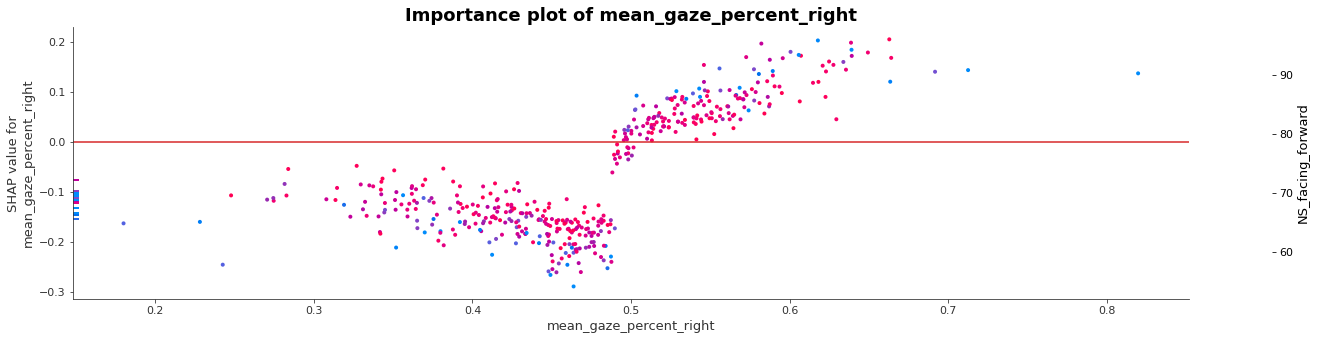

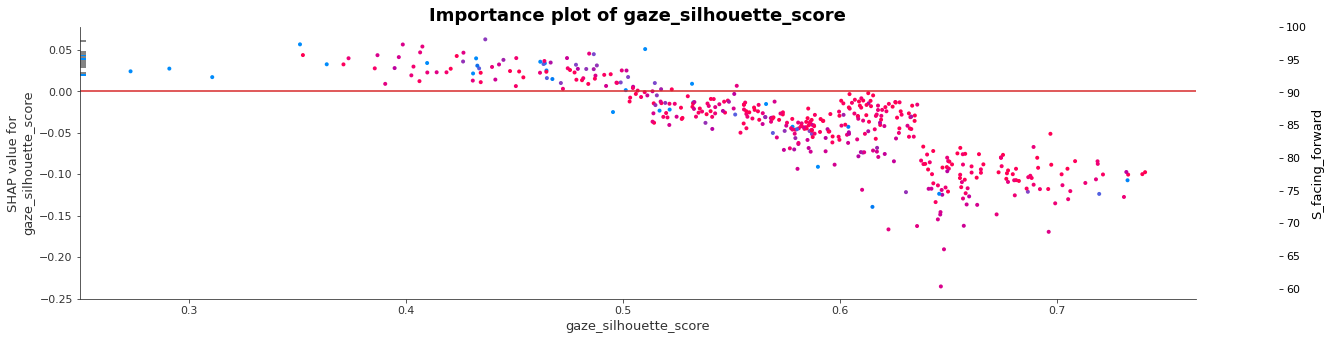

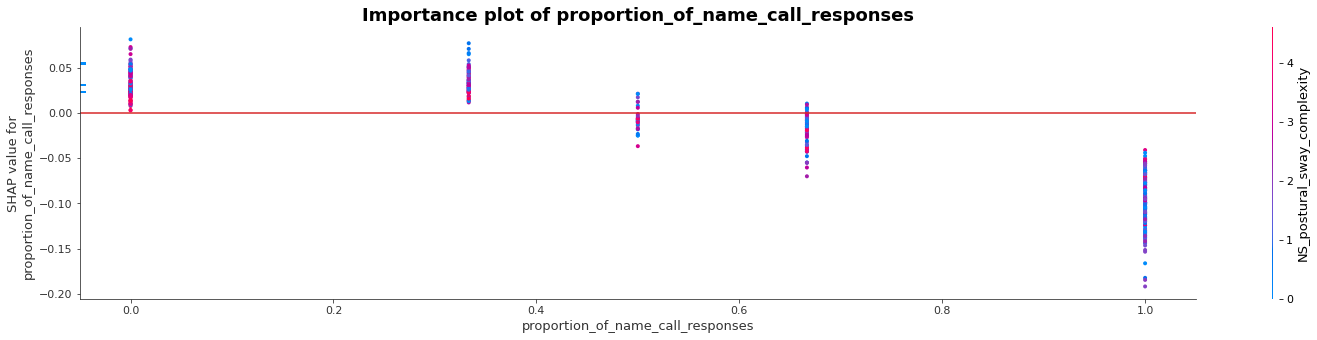

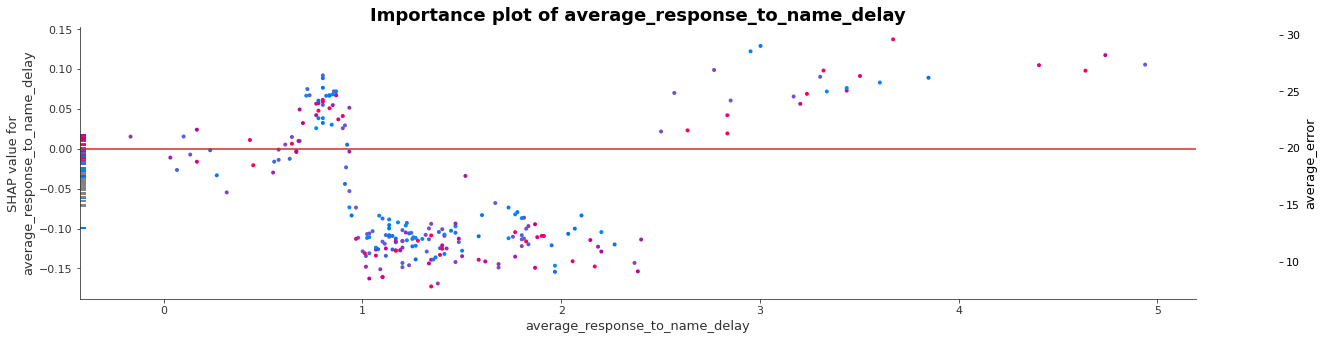

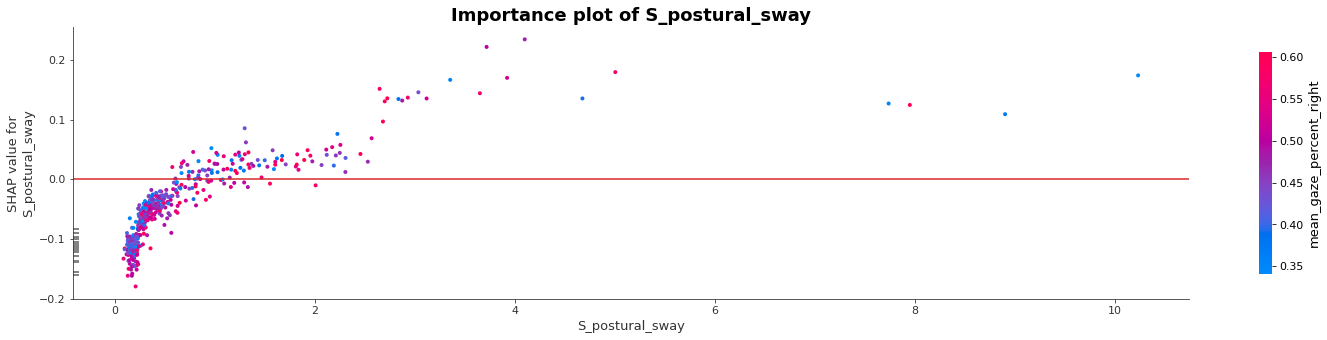

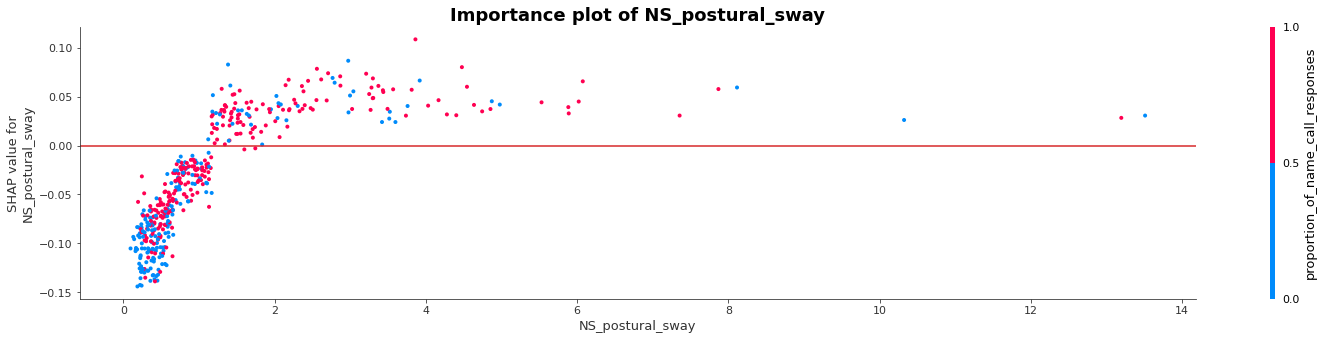

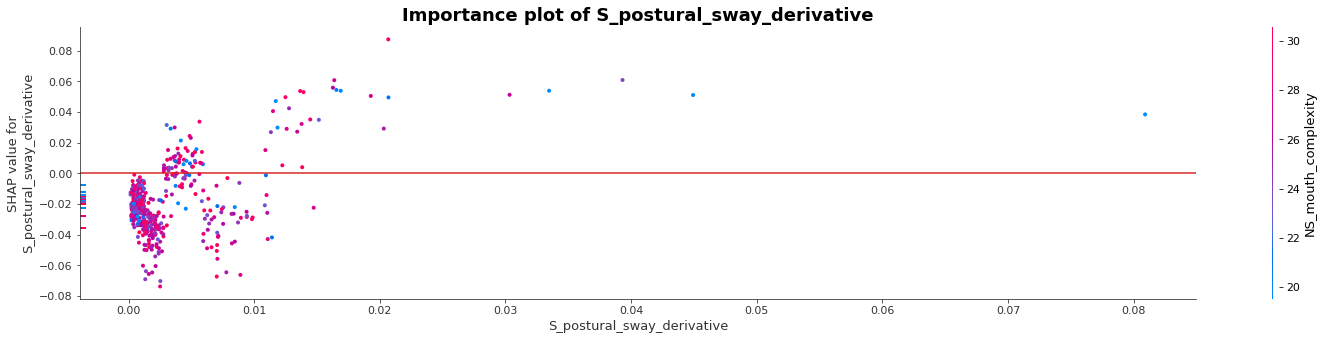

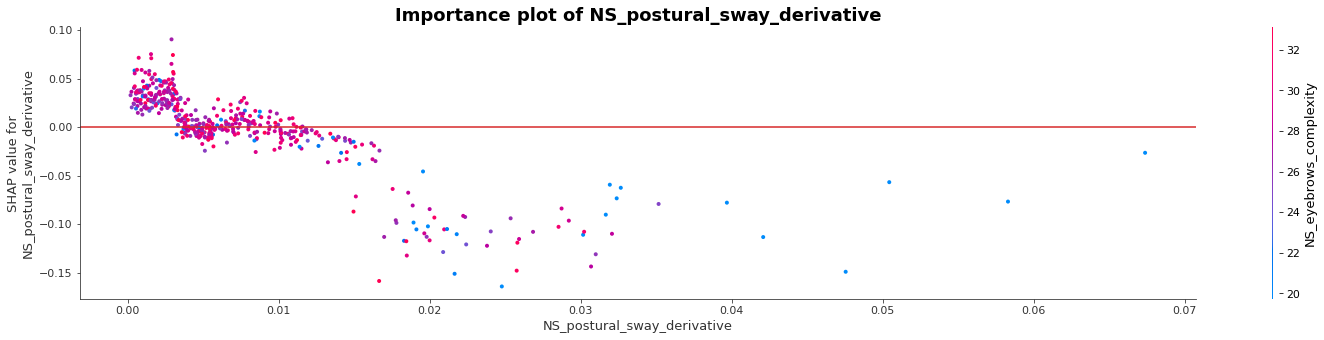

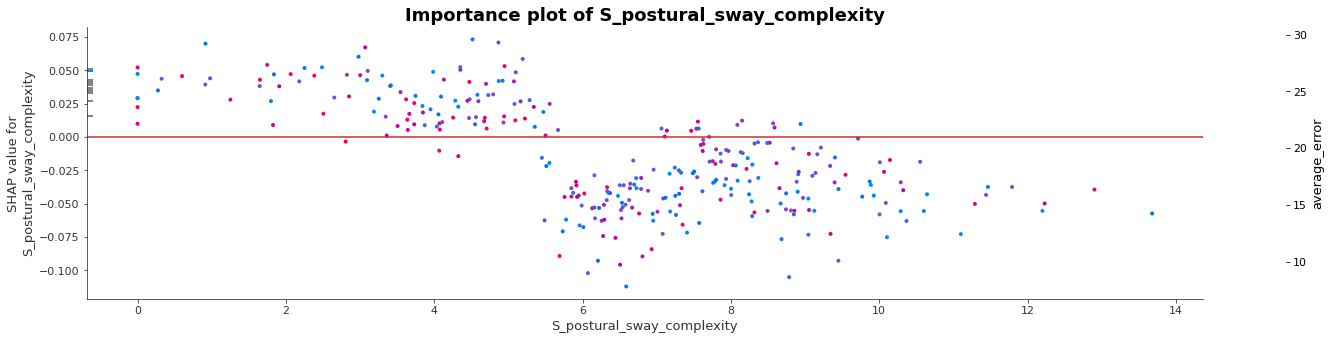

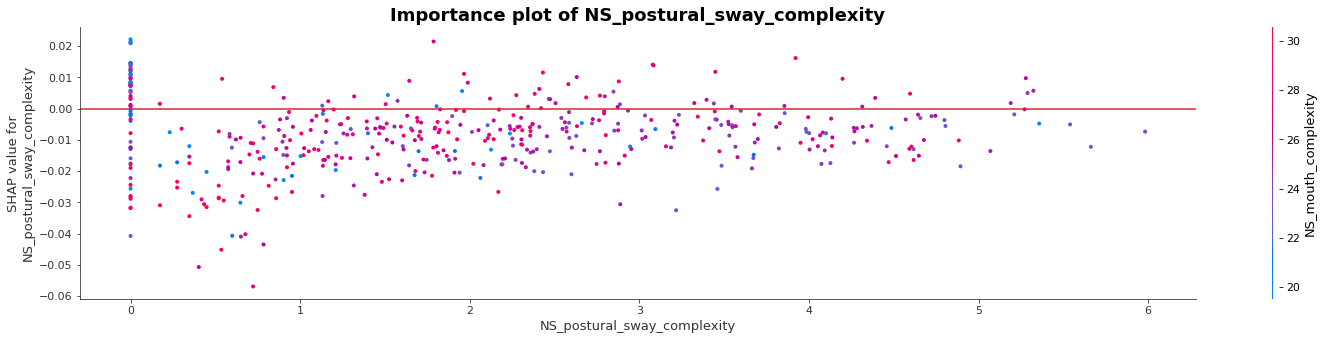

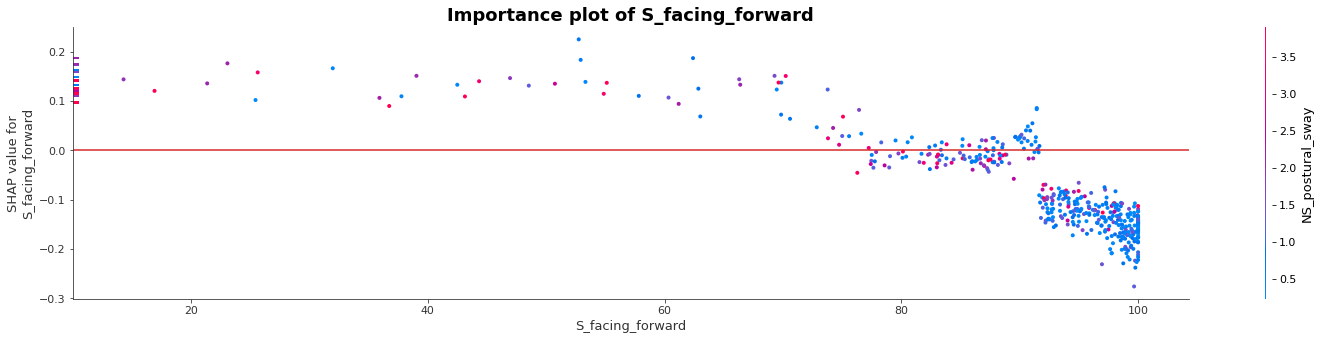

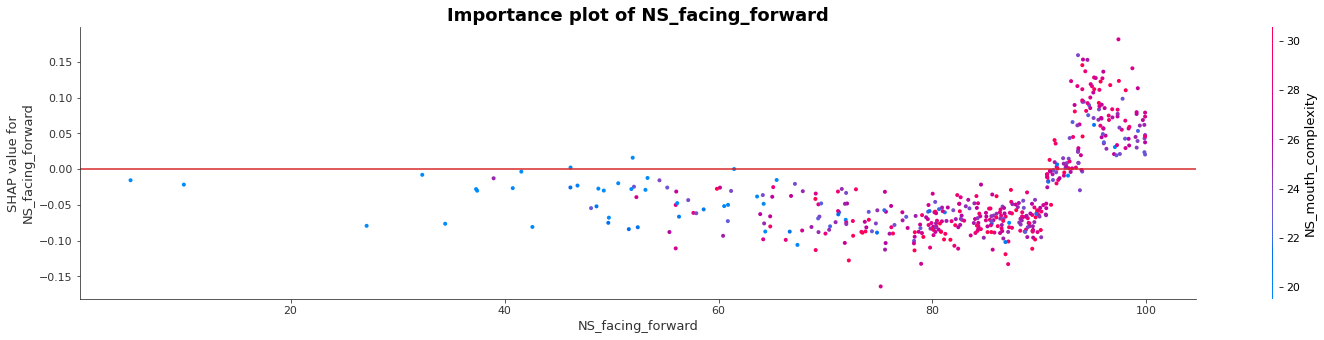

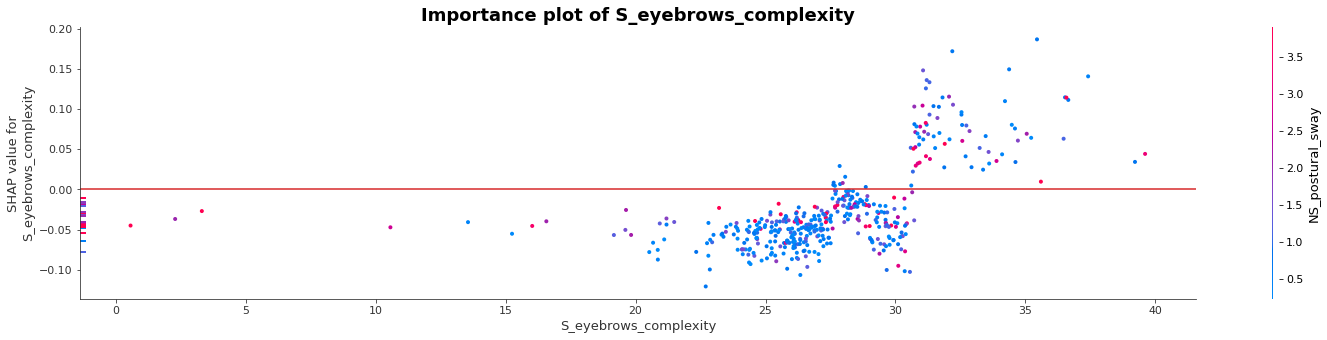

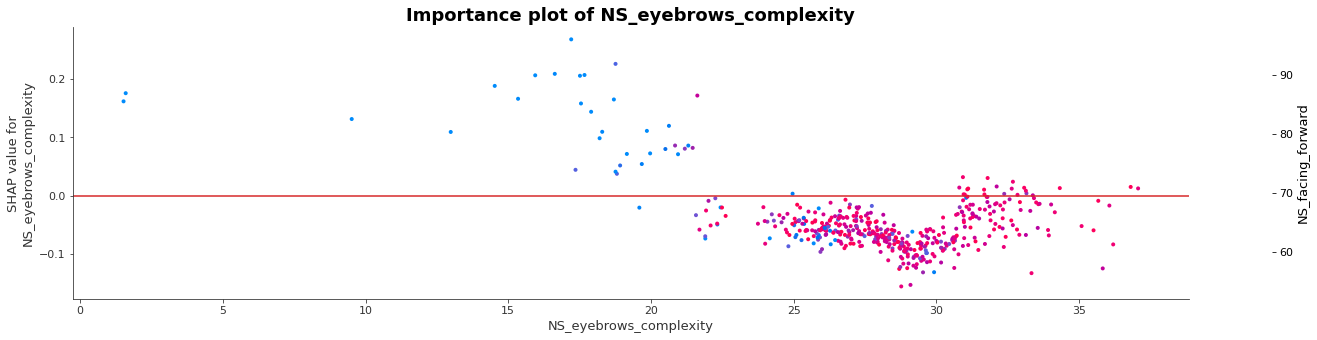

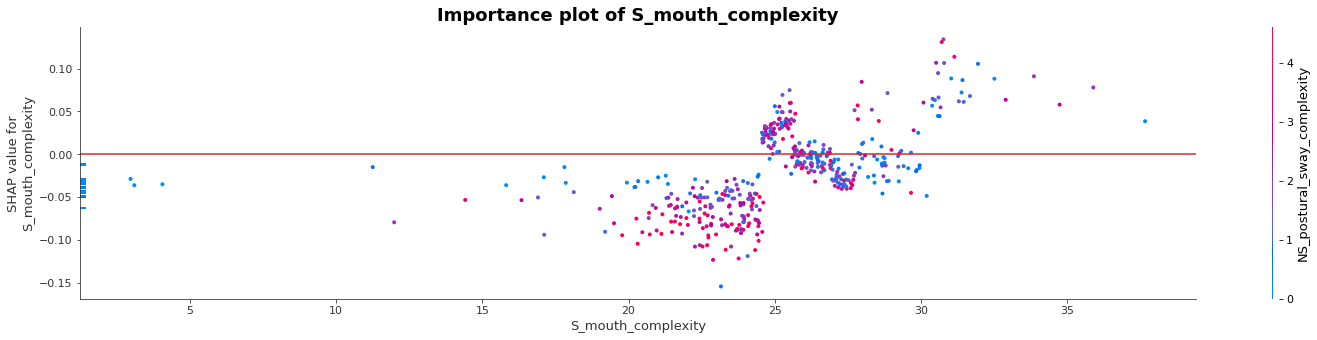

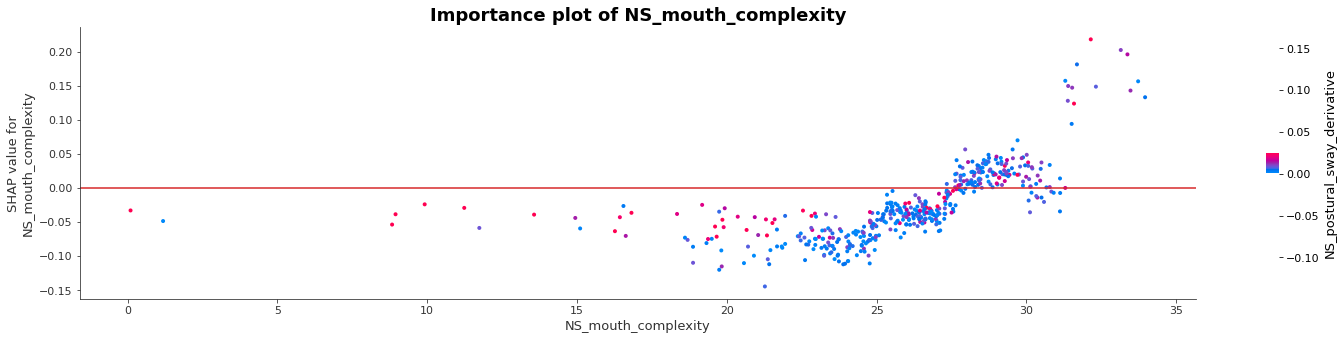

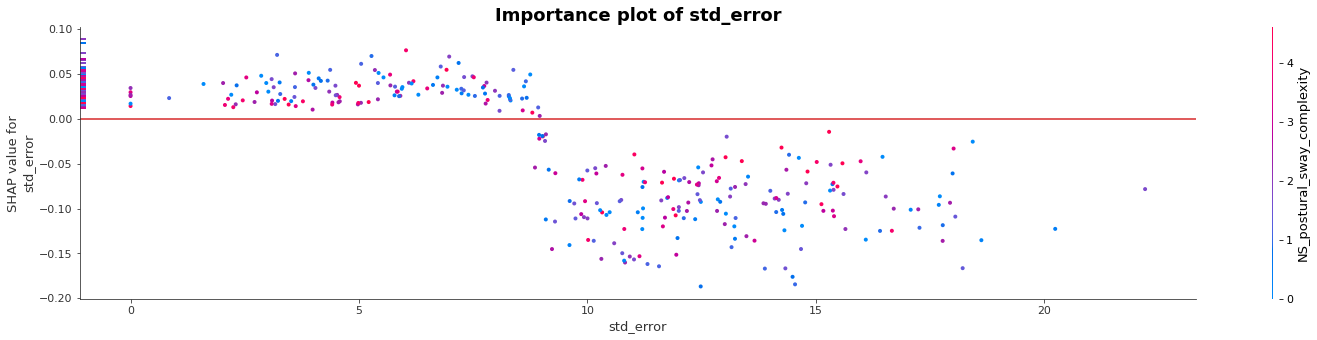

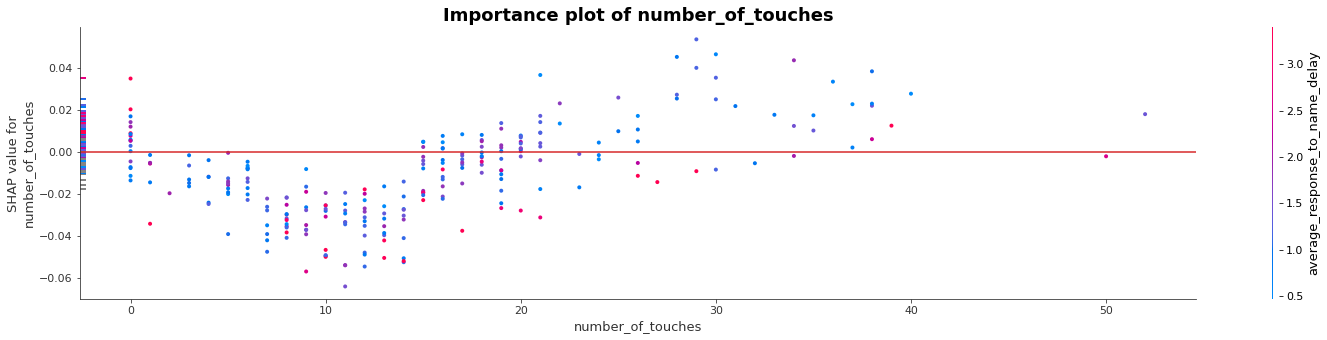

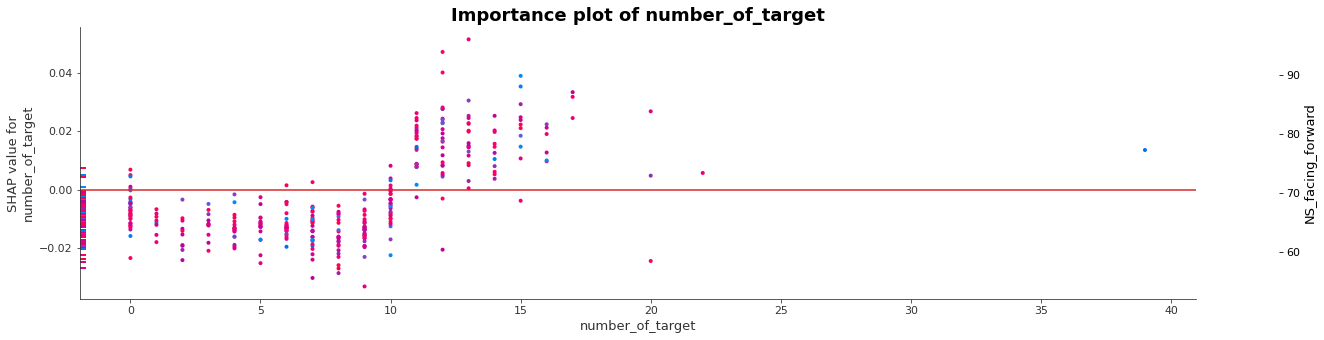

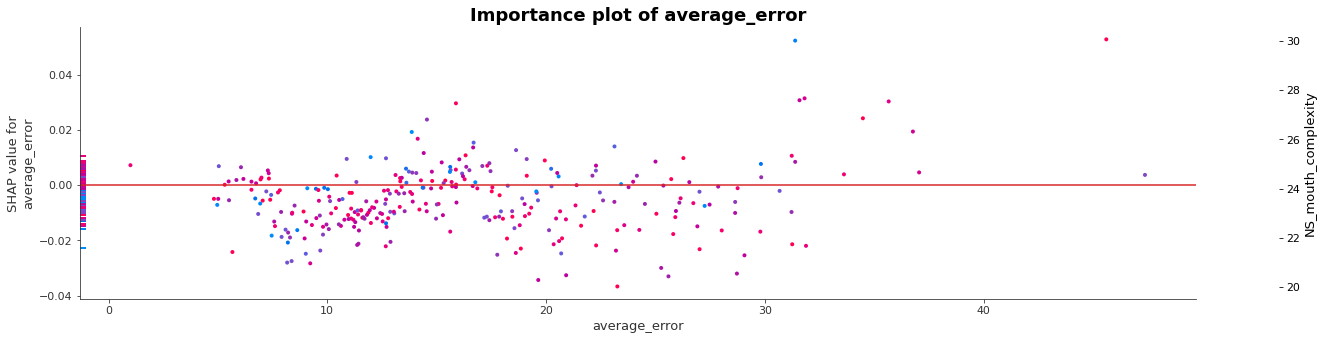

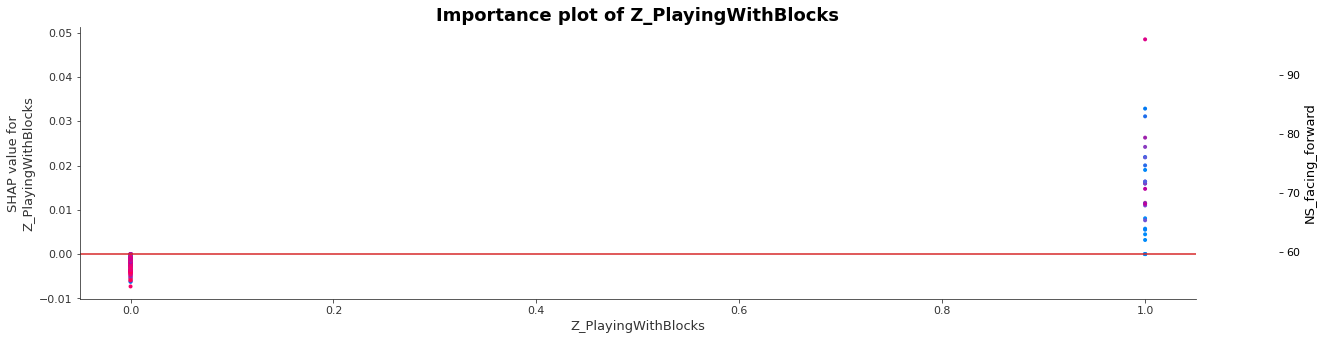

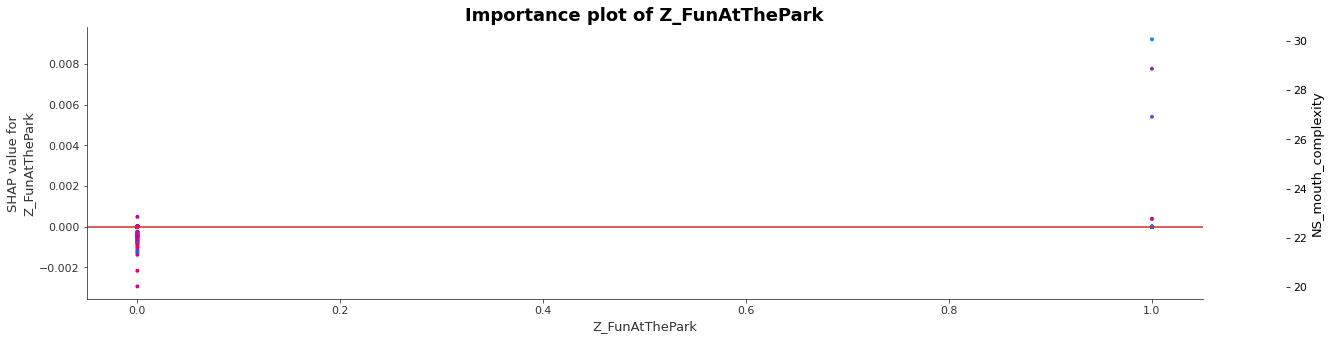

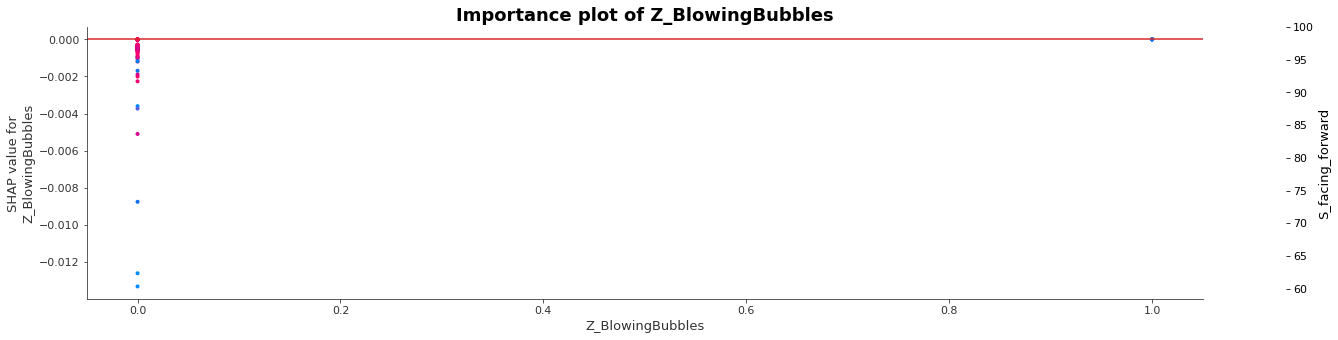

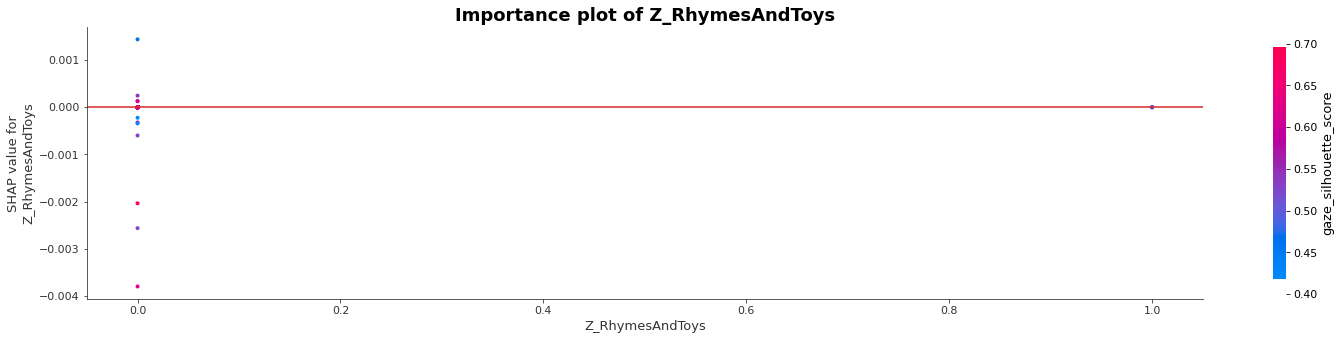

In [244]:
X = deepcopy(exp.dataset._X_train)
shap_values = np.zeros((n_participants, n_features))

for i in range(exp.dataset.num_samples):
    shap_values[i, :] = exp.shap_values[i, i, :]
    
    
for feat in exp.features_name:
    
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feat), weight='bold', fontsize=18)
    shap.dependence_plot(feat, shap_values, X, exp.features_name, ax=ax)
    
    

# Interaction effects


This section aims at studying the effect of the interactions between app features in the contributions of each app variables to the model and to the predictions.

1) We first train the model and store the Shap variables
2) We compute the Shap interaction effects, whicgh takes the form of a matrix of sixe N x K x K. For a sample, the sum of the matrix equal the prediction, 
   and the sum over rows (or columns) equal the shap value of that each features.
3) We study the average normalized contributions of principal and interaction effects across the dataset, by averaging all matrices across the dataset
4) We then take a few cases and draw their Shap matrix.

In order to assess which features interact the more and justify reporting them in the paper, we also add at step 3) and 4) a summary dataframe showing the most important information for each features:
- Its total principal contribution
- The sum of their interaction contribution 
- The feature having thr most interaction


In [565]:
def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary

**1) Model training**

In [ ]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=510, sample_weight=weighted_confidence_score)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()

**2) Computation of the normalized Shap Interaction matrices**

In [568]:
explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)

#Collect interaction shap values
shap_interaction_values = explainer.shap_interaction_values(exp.dataset.X_train)

# Normalize them per subjects to have percentages
# Note that the interaction values is oh shape [N x K x K], and that for a sample, the sum of the matrix equal the prediction, and the sum over rows (or columns) 
# equal the shap value of that each features! 
shap_interaction_values_normalized = shap_interaction_values/np.abs(shap_interaction_values).sum(axis=1).sum(axis=1)[:, np.newaxis, np.newaxis]

**3) Average normalized Shap Matrix**

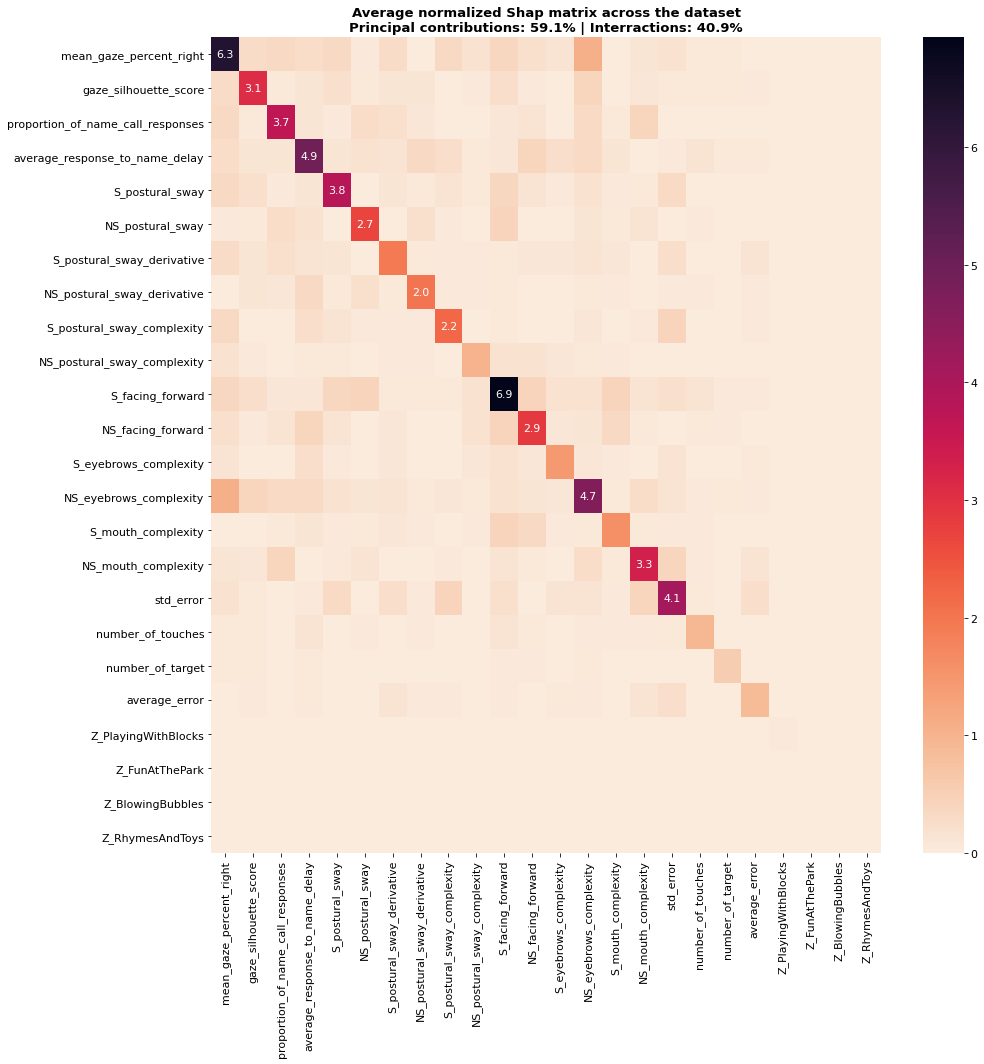

,total,main,interaction,first_interaction,first_interaction_name
S_facing_forward,10.661176,6.936886,3.724289,0.423214,NS_postural_sway
mean_gaze_percent_right,10.619289,6.304253,4.315036,1.076282,NS_eyebrows_complexity
NS_eyebrows_complexity,8.518838,4.6859,3.832938,1.076282,mean_gaze_percent_right
average_response_to_name_delay,8.027377,4.940634,3.086743,0.380863,NS_facing_forward
std_error,6.69546,4.133314,2.562146,0.416851,S_postural_sway_complexity
S_postural_sway,6.10666,3.799273,2.307386,0.377104,S_facing_forward
proportion_of_name_call_responses,5.825827,3.68052,2.145307,0.381312,NS_mouth_complexity
NS_mouth_complexity,5.380593,3.331059,2.049535,0.398771,std_error
NS_facing_forward,5.252613,2.858938,2.393675,0.411616,S_facing_forward
gaze_silhouette_score,5.154211,3.07891,2.0753,0.390428,NS_eyebrows_complexity


In [569]:
# Computation of the nornalized average Shap matrix 
matrix_shap = np.abs(shap_interaction_values_normalized).mean(axis=0)*100



# Build the anotation matrix for ploting
max_value = np.max(np.abs(matrix_shap))
df_shap = pd.DataFrame(matrix_shap, columns = exp.features_name, index = exp.features_name)
df_shap_label = np.zeros_like(matrix_shap).astype(str)
for row in range(matrix_shap.shape[0]):
    for col in range(matrix_shap.shape[0]):

        if np.abs(matrix_shap[row, col]) > 2: 
            df_shap_label[row, col] = str(np.round(matrix_shap[row, col], 1))
        else:
            df_shap_label[row, col] = ""

principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

fi(15, 15)
plt.title("Average normalized Shap matrix across the dataset\nPrincipal contributions: {:.1f}% | Interractions: {:.1f}%".format(principal_effect_sum, interaction_effect_sum), weight='bold')
sns.heatmap(df_shap, cmap=sns.color_palette("rocket_r", as_cmap=True), fmt="", annot=df_shap_label)
plt.show()
display_interaction_summary(matrix_shap)

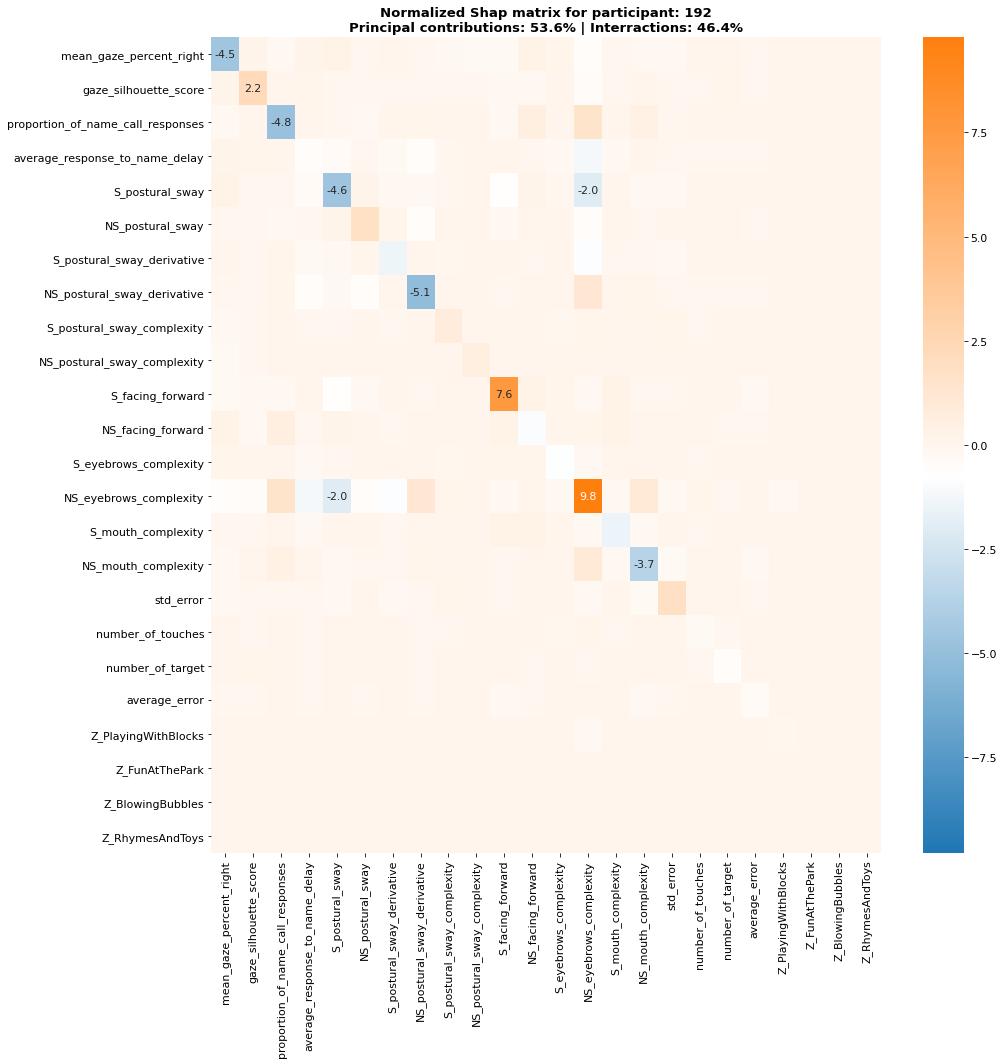

,total,main,interaction,first_interaction,first_interaction_name
NS_eyebrows_complexity,20.074476,9.785439,10.289037,2.029939,S_postural_sway
S_facing_forward,10.445469,7.57211,2.873359,0.679145,S_postural_sway
S_postural_sway,9.294238,4.634443,4.659795,2.029938,NS_eyebrows_complexity
proportion_of_name_call_responses,8.069813,4.822115,3.247697,1.514064,NS_eyebrows_complexity
NS_postural_sway_derivative,7.970467,5.14272,2.827747,1.164043,NS_eyebrows_complexity
mean_gaze_percent_right,7.48136,4.546025,2.935335,0.491617,NS_eyebrows_complexity
NS_mouth_complexity,6.127882,3.658801,2.469081,0.921772,NS_eyebrows_complexity
average_response_to_name_delay,3.898816,0.487644,3.411172,1.170185,NS_eyebrows_complexity
gaze_silhouette_score,3.759285,2.158117,1.601168,0.405753,NS_eyebrows_complexity
NS_postural_sway,3.547341,1.741539,1.805802,0.476349,NS_postural_sway_derivative


In [570]:

# Draw a random smaple and plot the shap matrix
idx_sample = np.random.randint(shap_interaction_values_normalized.shape[0])
matrix_shap = shap_interaction_values_normalized[idx_sample]*100

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:1F77B4-46.2:FFFFFF-100:FF7F0E
    (0.000, (0.122, 0.467, 0.706)),
    (0.462, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.498, 0.055))))

# Build the anotation matrix for ploting
max_value = np.max(np.abs(matrix_shap))
df_shap = pd.DataFrame(matrix_shap, columns = exp.features_name, index = exp.features_name)
df_shap_label = np.zeros_like(matrix_shap).astype(str)
for row in range(matrix_shap.shape[0]):
    for col in range(matrix_shap.shape[0]):

        if np.abs(matrix_shap[row, col]) > 2: 
            df_shap_label[row, col] = str(np.round(matrix_shap[row, col], 1))
        else:
            df_shap_label[row, col] = ""

principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

fi(15, 15)
plt.title("Normalized Shap matrix for participant: {}\nPrincipal contributions: {:.1f}% | Interractions: {:.1f}%".format(idx_sample, principal_effect_sum, interaction_effect_sum), weight='bold')
sns.heatmap(df_shap, cmap=cmap, vmin=-max_value, vmax=max_value, fmt="", annot=df_shap_label)
plt.show()
display_interaction_summary(matrix_shap)


## SHAP Summary Plot¶


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model. 

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

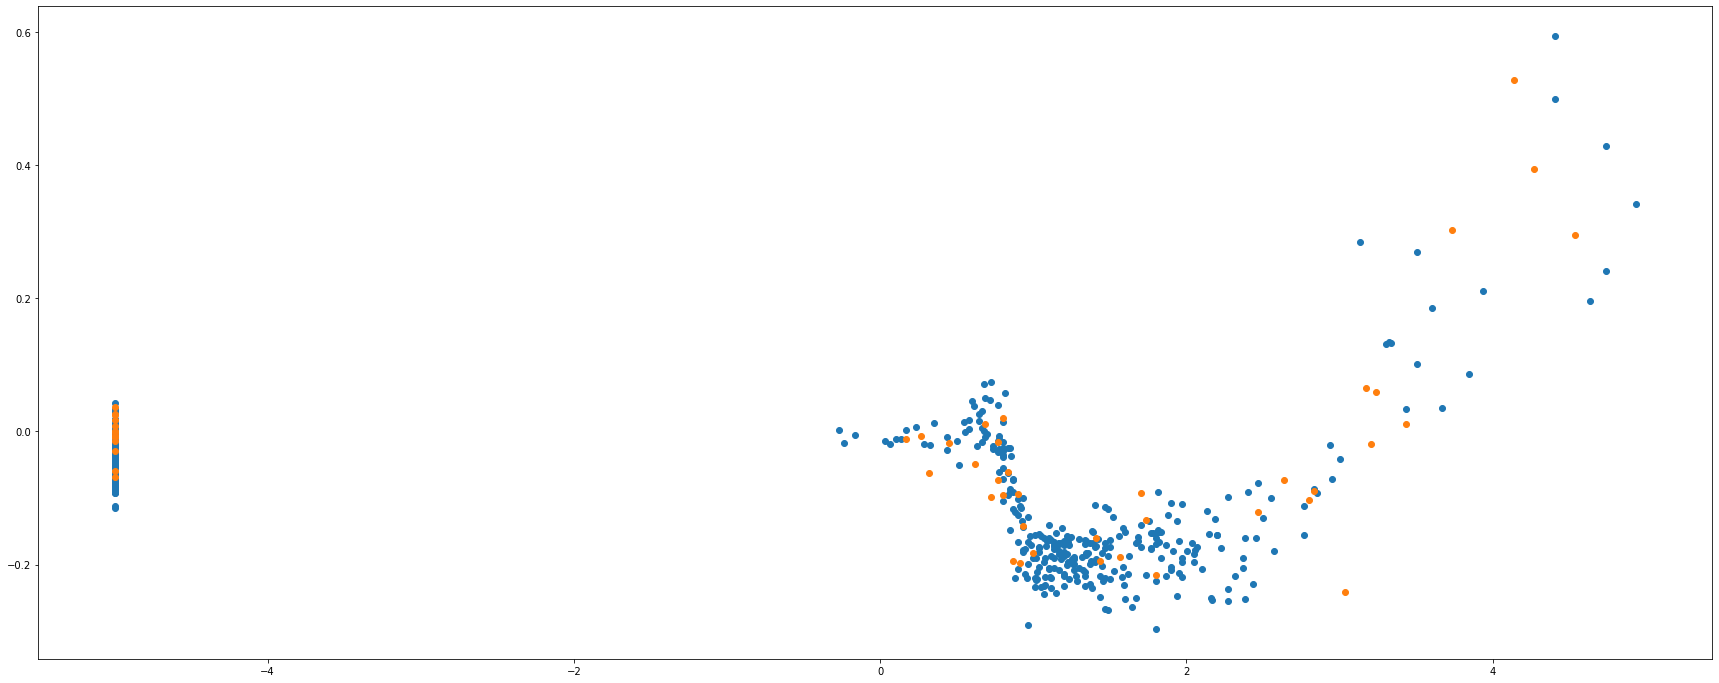

In [12]:
fi(30, 12)
plt.scatter(exp.dataset.X_train[exp.dataset.y_train==0, 3], exp.shap_values[exp.dataset.y_train==0, 3], color='tab:blue')
plt.scatter(exp.dataset.X_train[exp.dataset.y_train==1, 3], exp.shap_values[exp.dataset.y_train==1, 3], color='tab:orange')

# Comparisons of the Shap values between cross-validation and when fitting with all the data

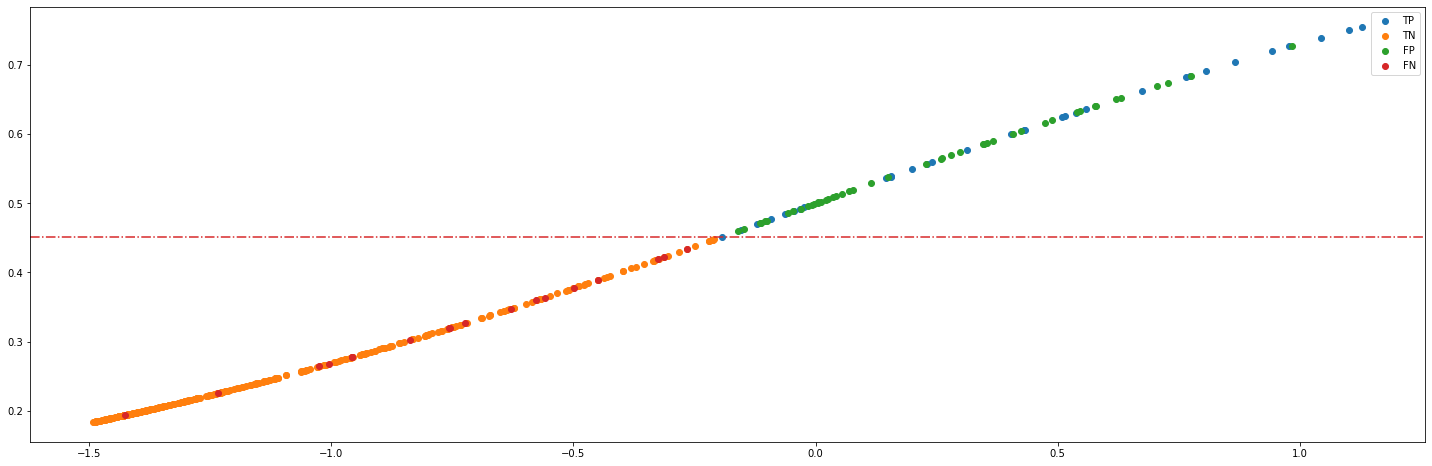

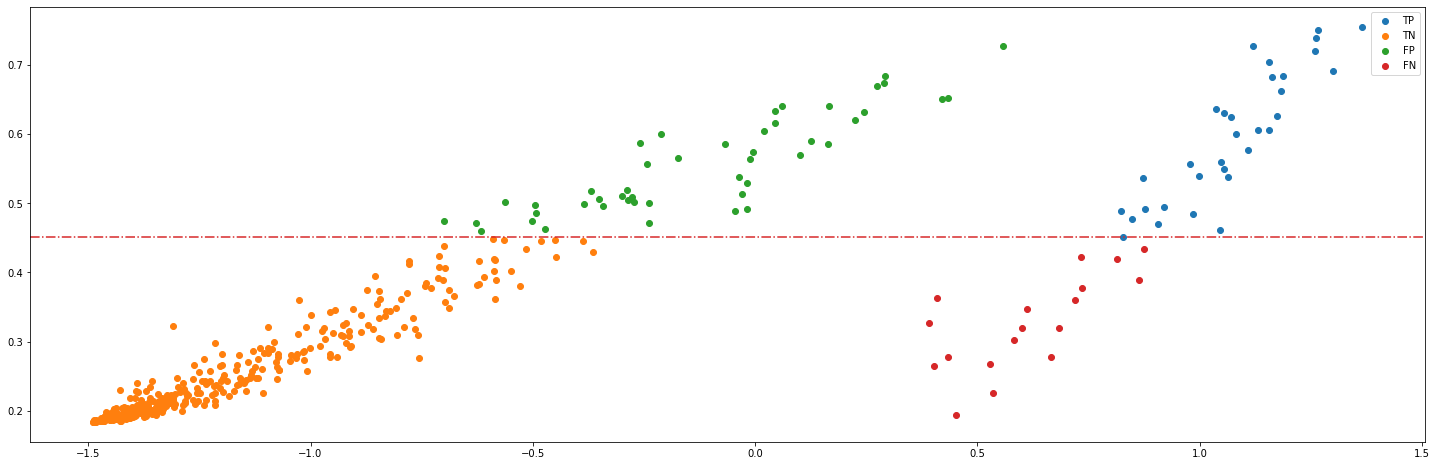

In [153]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = exp.shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

# Closer look at the Misclassified samples

In [39]:
import shap
explainer = shap.TreeExplainer(exp.model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [0.11800709]


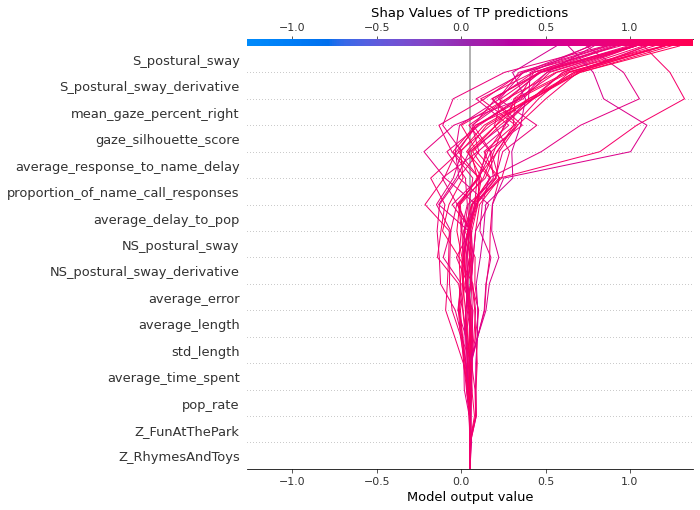

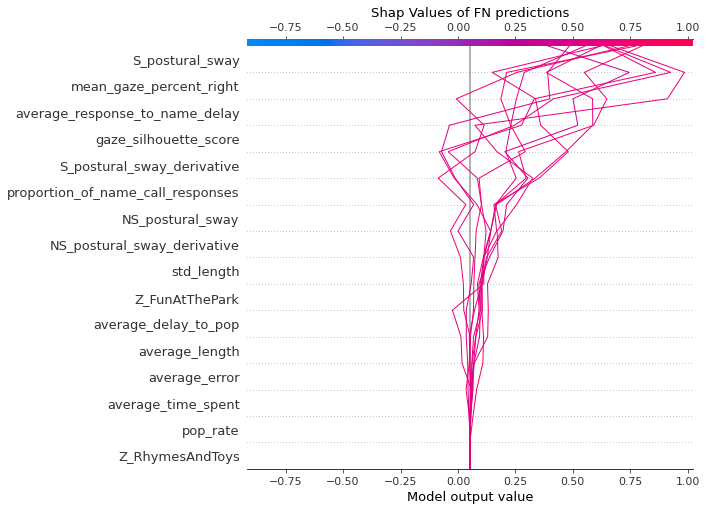

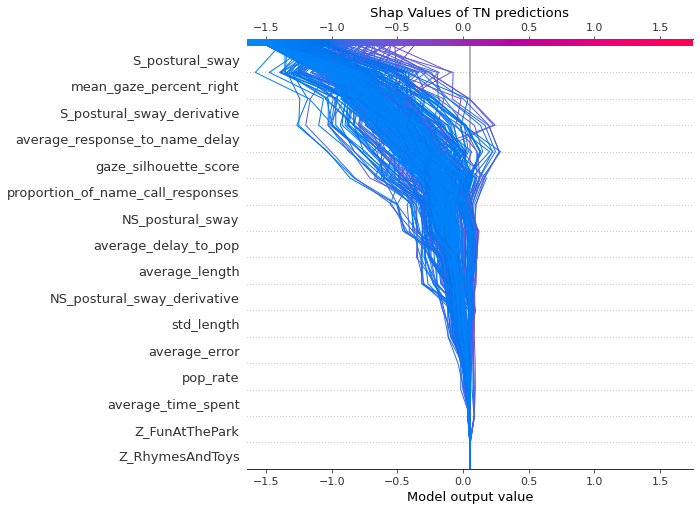

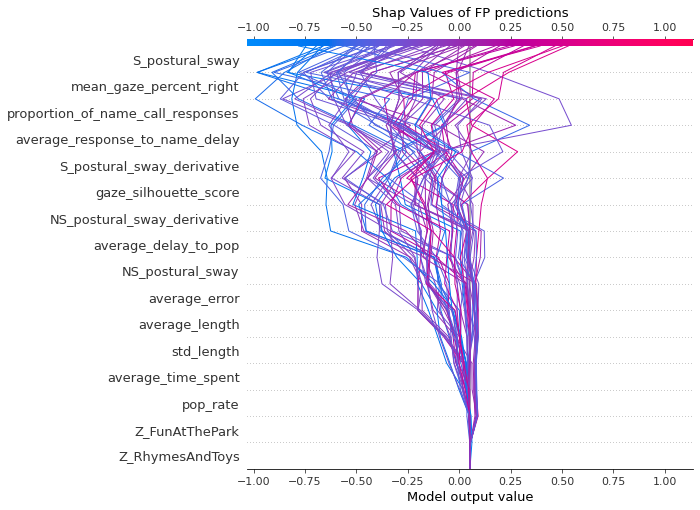

In [157]:
for name in ['TP','FN', 'TN', 'FP']:


    index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
    features = exp.predictions_df[exp.features_name]

    shap_values = explainer.shap_values(features)[index]
    shap_interaction_values = explainer.shap_interaction_values(features)
    hap_interaction_values = shap_interaction_values[index]
    shap.decision_plot(expected_value, shap_values, features, title="Shap Values of {} predictions".format(name))